In [1]:
import time
import numpy as np
from gep_config_parser import *
from data_wrangling import dataframe_to_dict
import pyomo.environ as pyo

from gep_main import run_model, prep_data, run_model_no_bounds
from gep_problem import GEPProblem

import torch

DTYPE = torch.float64

torch.set_default_dtype(DTYPE)

# DEVICE = (
#     torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# )

DEVICE = "cpu"

Parsing the config file
Initializing the solver
Using Gurobi


In [2]:
CONFIG_FILE_NAME        = "config.toml"
VISUALIZATION_FILE_NAME = "visualization.toml"

HIGHS  = "HiGHS"
GUROBI = "Gurobi"

SAMPLE_DURATION = 12 # 12 hours

## Step 0: Activate environment - ensure consistency accross computers
# print("Reading the data")
# print("Activating the environment")


In [3]:

## Step 1: parse the input data
print("Parsing the config file")

data = parse_config(CONFIG_FILE_NAME)
experiment = data["experiment"]
outputs_config = data["outputs_config"]

print("Initializing the solver")
optimizer_name = data["optimizer_config"]["solver"]

# Determine the optimizer
if optimizer_name == HIGHS:
    raise NotImplementedError(f"{optimizer_name}: Not implemented")
elif optimizer_name == GUROBI:
    
    print(f"Using {GUROBI}")
    optimizer = "gurobi_direct"
else:
    raise ValueError(f"{optimizer_name}: Not implemented")

Parsing the config file
Initializing the solver
Using Gurobi


In [4]:
for i, experiment_instance in enumerate(experiment["experiments"]):
    # Setup output dataframe
    df_res = pd.DataFrame(columns=["setup_time", "presolve_time", "barrier_time", "crossover_time", "restore_time", "objective_value"])

    input_T, input_N, input_G, input_L, input_pDemand, input_pGenAva, input_pVOLL, input_pWeight, input_pRamping, input_pInvCost, input_pVarCost, input_pUnitCap, input_pExpCap, input_pImpCap = prep_data(experiment_instance)

    T_ranges = [range(i, i + SAMPLE_DURATION, 1) for i in range(1, len(input_T), SAMPLE_DURATION)]
    objective_values = []
    times = []
    models = []
    solvers = []
    for t in T_ranges[:1]:
        # Run one experiment for j repeats
        model, solver, time_taken = run_model(experiment_instance, t, input_N, input_G, input_L, input_pDemand, input_pGenAva, input_pVOLL, input_pWeight, input_pRamping, input_pInvCost, input_pVarCost, input_pUnitCap, input_pExpCap, input_pImpCap)
        models.append(model)
        solvers.append(solver)

Wrangling the input data
Populating the model
Adding model variables
Formulating the objective
Adding model constraints
Solving the optimization problem
Set parameter OutputFlag to value 1
Set parameter LogFile to value "outputs/Gurobi/output.txt"
Set parameter Crossover to value 0
Set parameter FeasibilityTol to value 1e-09
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 22.3.0 22D49)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
FeasibilityTol  1e-09
Method  2
Crossover  0
QCPDual  1

Optimize a model with 140 rows, 113 columns and 467 nonzeros
Model fingerprint: 0x93c00021
Coefficient statistics:
  Matrix range     [7e-02, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+03, 3e+04]
  RHS range        [4e+03, 3e+04]
Presolve removed 126 rows and 104 columns
Presolve time: 0.00s
Presolved: 14 rows, 9 columns, 42 nonzeros
Ordering time

In [5]:
GEP_data = GEPProblem(input_T, input_N, input_G, input_L, input_pDemand, input_pGenAva, input_pVOLL, input_pWeight, input_pRamping, input_pInvCost, input_pVarCost, input_pUnitCap, input_pExpCap, input_pImpCap, sample_duration=SAMPLE_DURATION, shuffle=False)
GEP_X = GEP_data.trainX_raw

Size of train set: 584
Size of val set: 73
Size of test set: 73
Size of mu: 285
Size of lambda: 36
Number of variables (size of y): 111
Number of inputs (size of X): 72


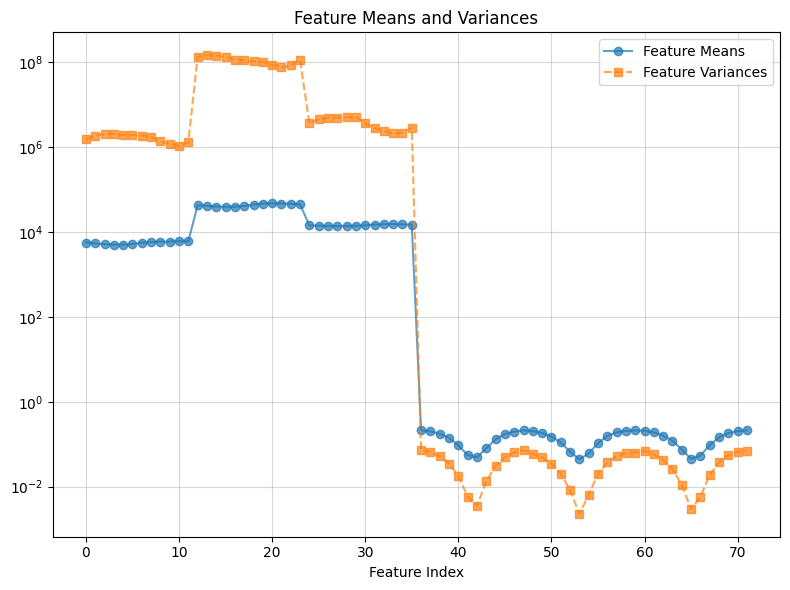

In [6]:
import matplotlib.pyplot as plt
GEP_means = torch.mean(GEP_X, axis=0)
GEP_vars = torch.var(GEP_X, axis=0)

# Plot the means and variances of all features on the same figure with a logarithmic Y-axis
plt.figure(figsize=(8, 6))
plt.plot(GEP_means, label='Feature Means', marker='o', linestyle='-', alpha=0.7)
plt.plot(GEP_vars, label='Feature Variances', marker='s', linestyle='--', alpha=0.7)
plt.yscale('log')
plt.title('Feature Means and Variances')
plt.xlabel('Feature Index')
# plt.ylabel('Logarithmic Scale')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [7]:
GEP_X_scaled = GEP_data.trainX
GEP_X_raw = GEP_data.trainX_raw

pDemand_scaled, pGenAva_scaled = GEP_data._split_x(GEP_X_scaled)
pDemand, pGenAva = GEP_data._split_x(GEP_X_raw)
pDemand_unnormalized = GEP_data.pDemand_scaler.inverse_scale(pDemand_scaled)
pGenAva_unnormalized = GEP_data.pGenAva_scaler.inverse_scale(pGenAva_scaled)
print(pDemand.mean())
print(pDemand_unnormalized.mean())

assert np.allclose(pDemand, pDemand_unnormalized, atol=1e-9)


tensor(20998.4611)
tensor(20998.4611)


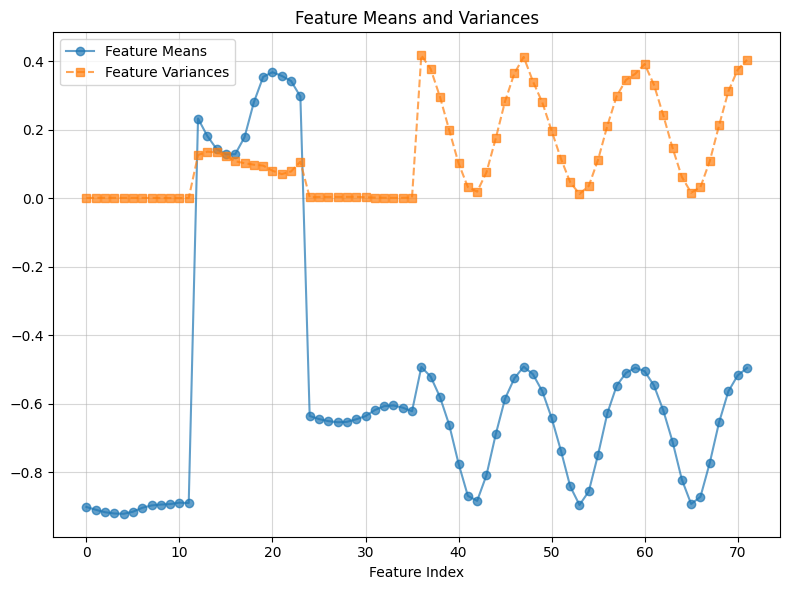

In [8]:
import matplotlib.pyplot as plt
GEP_means = torch.mean(GEP_X_scaled, axis=0)
GEP_vars = torch.var(GEP_X_scaled, axis=0)

# Plot the means and variances of all features on the same figure with a logarithmic Y-axis
plt.figure(figsize=(8, 6))
plt.plot(GEP_means, label='Feature Means', marker='o', linestyle='-', alpha=0.7)
plt.plot(GEP_vars, label='Feature Variances', marker='s', linestyle='--', alpha=0.7)
# plt.yscale('log')
plt.title('Feature Means and Variances')
plt.xlabel('Feature Index')
# plt.ylabel('Logarithmic Scale')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()